# SDC Method Comparison

**Author:** Noah Perry

**Overview:** This notebook contains empirical experiments comparing the performance of three SDC methods (RWN, rank swapping, microaggregation) using a variety of privacy and utility metrics using the bodyfat dataset from the mfp R package:

**Data description:** The bodyfat data contains body measurements of 252 adult males and two
estimates of their body fat percentage calculated using the Brozek and
Siri equations. 

Link to documentation for mfp: https://cran.r-project.org/web/packages/mfp/mfp.pdf

**SDC Methods:**
- We have implemented RWN in R: ***GitHub link to be added***
- For rank swapping and microaggregation, we use the `rankSwap()` and `microaggregation()` functions in the sdcMicro R package. 
- We use MDAV microaggregation, which is the default method in the sdcMicro `microaggregation()` function


**Privacy Metrics**
 - Distance to closest record (DCR)
 - Standard deviation interval disclosure risk (using `dRisk()` from sdcMicro)
 - Robust Mahalanobis distance internval disclosure risk (using `dRiskRMD()` from sdcMicro)

**Utility Metrics**
 - Pearson correlations
 - PCA loadings
 - Regression coefficients
 - Regression R-squared
 
**Tuning Parameters**
 
We compare the three methods by looking at each metric across 15 different choices of tuning parameters

| Index | RWN (eps) | Rank Swap (P) | Microaggregation (k) |
| --- | --- | --- | --- |
| 1  | 0.25 | 0.12 | 2  |
| 2  | 0.30 | 0.15 | 3  |
| 3  | 0.35 | 0.18 | 4  |
| 4  | 0.40 | 0.21 | 5  |
| 5  | 0.45 | 0.24 | 6  |
| 6  | 0.50 | 0.27 | 7  |
| 7  | 0.55 | 0.30 | 8  |
| 8  | 0.60 | 0.33 | 9  |
| 9  | 0.65 | 0.36 | 10 |
| 10 | 0.70 | 0.39 | 11 |
| 11 | 0.75 | 0.42 | 12 |
| 12 | 0.80 | 0.45 | 13 |
| 13 | 0.85 | 0.48 | 14 |
| 14 | 0.90 | 0.51 | 15 |
| 15 | 0.95 | 0.54 | 16 |

The index column in the table above is used as the x-axis in all the plots in this notebook.

For all RWN experiment, we use RWN with $k=5$ and $q=1$.

### Setup

In [1]:
# Package installation (for running notebook for first time)
#install.packages("corrplot")
#install.packages("gtools")
#install.packages("infotheo")
#install.packages("mfp")
#install.packages("pdist")
#install.packages("regtools")
#install.packages("sdcMicro")

In [2]:
rm(list = ls())

# Packages
library(corrplot)
library(gtools)
library(infotheo)
library(sdcMicro)
library(regtools)
# mfp package is loaded in import and clean program
# pdist package is loaded in RWN.R code

# Filepath
fp <- # [UPDATE WITH FILEPATH TO MAIN RWN REPO]

# RWN code
source(paste0(fp,"R/RWN.R"))

# Privacy metrics
source(paste0(fp,"Experiments/NP/Distance to Closest Record Function.R"))

# Utility metrics
source(paste0(fp,"Experiments/NP/Utility Analysis Functions.R"))

# Set seed for reproducibility of RWN results
set.seed(58681866)

# Define e() function
e <- function(x) {
  eval(parse(text = x))
}

corrplot 0.92 loaded

Loading required package: FNN


Attaching package: 'FNN'


The following object is masked from 'package:infotheo':

    entropy







*********************



Latest version of regtools at GitHub.com/matloff


Type ?regtools to see function list by category






Attaching package: 'regtools'


The following object is masked from 'package:infotheo':

    discretize




### Import and Clean Data

In [3]:
# Run import and clean program
source(paste0(fp, "Experiments/NP/01 Import and Clean bodyfat Data (mfp).R"))

Loading required package: survival



In [4]:
str(bf_clean)

'data.frame':	241 obs. of  14 variables:
 $ bodyfat_pct: num  12.3 6.1 25.3 10.4 28.7 20.9 19.2 12.4 4.1 11.7 ...
 $ age        : int  23 22 22 26 24 24 26 25 25 23 ...
 $ weight     : num  154 173 154 185 184 ...
 $ height     : num  67.8 72.2 66.2 72.2 71.2 ...
 $ neck       : num  36.2 38.5 34 37.4 34.4 39 36.4 37.8 38.1 42.1 ...
 $ chest      : num  93.1 93.6 95.8 101.8 97.3 ...
 $ abdomen    : num  85.2 83 87.9 86.4 100 94.4 90.7 88.5 82.5 88.6 ...
 $ hip        : num  94.5 98.7 99.2 101.2 101.9 ...
 $ thigh      : num  59 58.7 59.6 60.1 63.2 66 58.4 60 62.9 63.1 ...
 $ knee       : num  37.3 37.3 38.9 37.3 42.2 42 38.3 39.4 38.3 41.7 ...
 $ ankle      : num  21.9 23.4 24 22.8 24 25.6 22.9 23.2 23.8 25 ...
 $ biceps     : num  32 30.5 28.8 32.4 32.2 35.7 31.9 30.5 35.9 35.6 ...
 $ forearm    : num  27.4 28.9 25.2 29.4 27.7 30.6 27.8 29 31.1 30 ...
 $ wrist      : num  17.1 18.2 16.6 18.2 17.7 18.8 17.7 18.8 18.2 19.2 ...


### Make Perturbed Datasets

In [5]:
# Number of Perturbed Datasets to Make for RWN and Rank Swapping
reps <- 100
reps_vec <- seq(1, reps, 1)

In [6]:
### Tuning parameters ###
# RWN
eps_vec <- seq(0.25, 0.95, 0.05)

# Rank swapping
P_dec_vec <- seq(0.12, 0.54, 0.03) 
P_pct_vec <- P_dec_vec * 100

# Microaggregation
aggr_vec <- seq(2, 16, 1)

In [7]:
# RWN
for(i in 1:length(eps_vec)){
    for(j in reps_vec){
        assign(paste0("bf_pert_eps", eps_vec[i], "_k5_v", j), rwn1(bf_clean, eps = eps_vec[i], k = 5, q = 1))
    }
}

In [8]:
# Rank swapping
for(i in 1:length(P_dec_vec)){
    for(j in reps_vec){
        assign(paste0("bf_rs_P", P_pct_vec[i], "_v", j),
          rankSwap(bf_clean, P = P_dec_vec[i], seed = j))
    }
}

In [9]:
# Microaggregation
for(i in 1:length(aggr_vec)){        
    assign(paste0("bf_ma_k", aggr_vec[i]),
           microaggregation(bf_clean, aggr = aggr_vec[i])$mx)
}

### Privacy Comparison: Distance to Closest Record
Minimum L2 distance between values for each record in the original data

This is similar to Syntegra's DCR metric.

In [10]:
distO_rwn_k5_mat <- matrix(nrow = length(eps_vec), ncol = reps)
distO_rs_mat <- matrix(nrow = length(eps_vec), ncol = reps)
distO_ma_vec <- vector(mode = "numeric", length = length(eps_vec))

for(i in 1:length(eps_vec)){
    for(j in reps_vec){
        distO_rwn_k5_mat[i,j] <- calc_DCR(bf_clean, 
                                      e(paste0("bf_pert_eps", eps_vec[i], "_k5_v", j, "$zperturb")),
                                      dist_metric = "L2",
                                      foreach_data = "orig",
                                      uselog = FALSE)
        distO_rs_mat[i,j] <- calc_DCR(bf_clean, 
                                   e(paste0("bf_rs_P", P_pct_vec[i], "_v", j)),
                                   dist_metric = "L2",
                                   foreach_data = "orig",
                                   uselog = FALSE)
    }
    distO_ma_vec[i] <- calc_DCR(bf_clean, 
                                e(paste0("bf_ma_k", aggr_vec[i])),
                                dist_metric = "L2",
                                foreach_data = "orig",
                                uselog = FALSE)
}

distO_rwn_k5_vec <- rowMeans(distO_rwn_k5_mat)
distO_rs_vec <- rowMeans(distO_rs_mat)

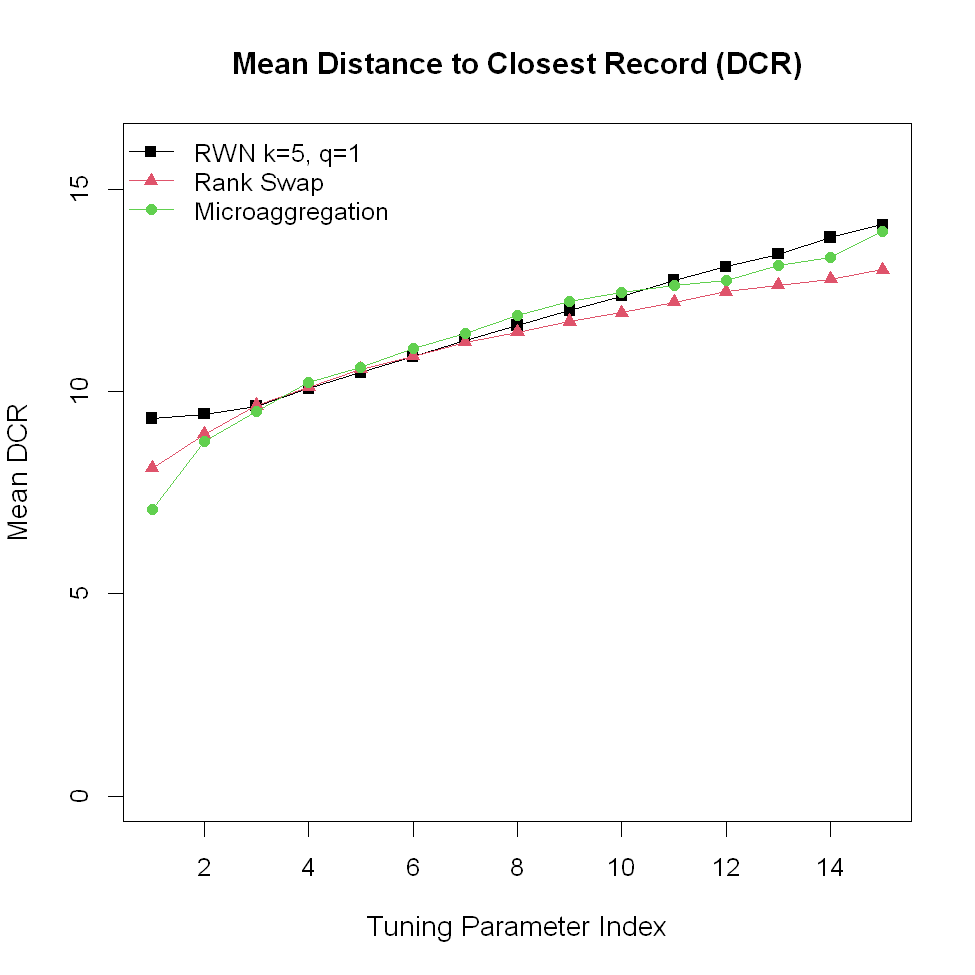

In [11]:
options(repr.plot.width=6.5, repr.plot.height=6.5, repr.plot.res = 150)

plot(distO_rwn_k5_vec, 
     main = "Mean Distance to Closest Record (DCR)",
     #sub = "Note: Higher mean DCR implies lower disclosure risk", col.sub = "gray30", cex.sub = 1.1,
     col = 1, pch = 15,
     xlim = c(1,15), ylim = c(0,16),
     xlab = "Tuning Parameter Index", ylab = "Mean DCR", cex.lab = 1.1)
lines(distO_rwn_k5_vec, col = 1)

points(distO_rs_vec, col = 2, pch = 17)
lines(distO_rs_vec, col = 2)

points(distO_ma_vec, col = 3, pch = 19)
lines(distO_ma_vec, col = 3)

legend(x = "topleft", lty = 1, col = 1:3, pch = c(15,17,19), bty = "n",
       legend = c("RWN k=5, q=1", "Rank Swap", "Microaggregation"))

### Privacy Comparison: Interval Disclosure Risk

#### Standard deviation-based intervals
Description from sdcMicro: "An interval (based on the standard deviation) is built around each value of the perturbed value. Then we look if the original values lay in these intervals or not. With parameter k one can enlarge or down scale the interval"

See https://sdctools.github.io/sdcMicro/reference/dRisk.html

#### Robust Mahalanobis distance-based intervals
See https://sdctools.github.io/sdcMicro/reference/dRiskRMD.html

In [12]:
# Standard deviation-based intervals
k_val = 1

SDID_rwn_k5_mat <- matrix(nrow = length(eps_vec), ncol = reps)
SDID_rs_mat <- matrix(nrow = length(eps_vec), ncol = reps)
SDID_ma_vec <- vector(mode = "numeric", length = length(eps_vec))


for(i in 1:length(eps_vec)){
    for(j in reps_vec){
        SDID_rwn_k5_mat[i,j] <- dRisk(obj = bf_clean, 
                                      xm = e(paste0("bf_pert_eps", eps_vec[i], "_k5_v", j, "$zperturb")), 
                                      k = k_val)
        SDID_rs_mat[i,j] <- dRisk(obj = bf_clean, 
                                  xm = e(paste0("bf_rs_P", P_pct_vec[i], "_v", j)), 
                                  k = k_val)
    }
    SDID_ma_vec[i] <- dRisk(obj = bf_clean, 
                            xm = e(paste0("bf_ma_k", aggr_vec[i])), 
                            k = k_val)
}

SDID_rwn_k5_vec <- rowMeans(SDID_rwn_k5_mat)
SDID_rs_vec <- rowMeans(SDID_rs_mat)

In [13]:
# Robust Mahalanobis distance-based intervals
RMDID_rwn_k5_mat <- matrix(nrow = length(eps_vec), ncol = reps)
RMDID_rs_mat <- matrix(nrow = length(eps_vec), ncol = reps)
RMDID_ma_vec <- vector(mode = "numeric", length = length(eps_vec))

for(i in 1:length(eps_vec)){
    for(j in reps_vec){
        RMDID_rwn_k5_mat[i,j] <- dRiskRMD(obj = bf_clean, 
                                          xm = e(paste0("bf_pert_eps", eps_vec[i], "_k5_v", j, "$zperturb")))$risk1
        RMDID_rs_mat[i,j] <- dRiskRMD(obj = bf_clean, 
                                      xm = e(paste0("bf_rs_P", P_pct_vec[i], "_v", j)))$risk1  
    }
    RMDID_ma_vec[i] <- dRiskRMD(obj = bf_clean, 
                                xm = e(paste0("bf_ma_k", aggr_vec[i])))$risk1

    
}

RMDID_rwn_k5_vec <- rowMeans(RMDID_rwn_k5_mat)
RMDID_rs_vec <- rowMeans(RMDID_rs_mat)

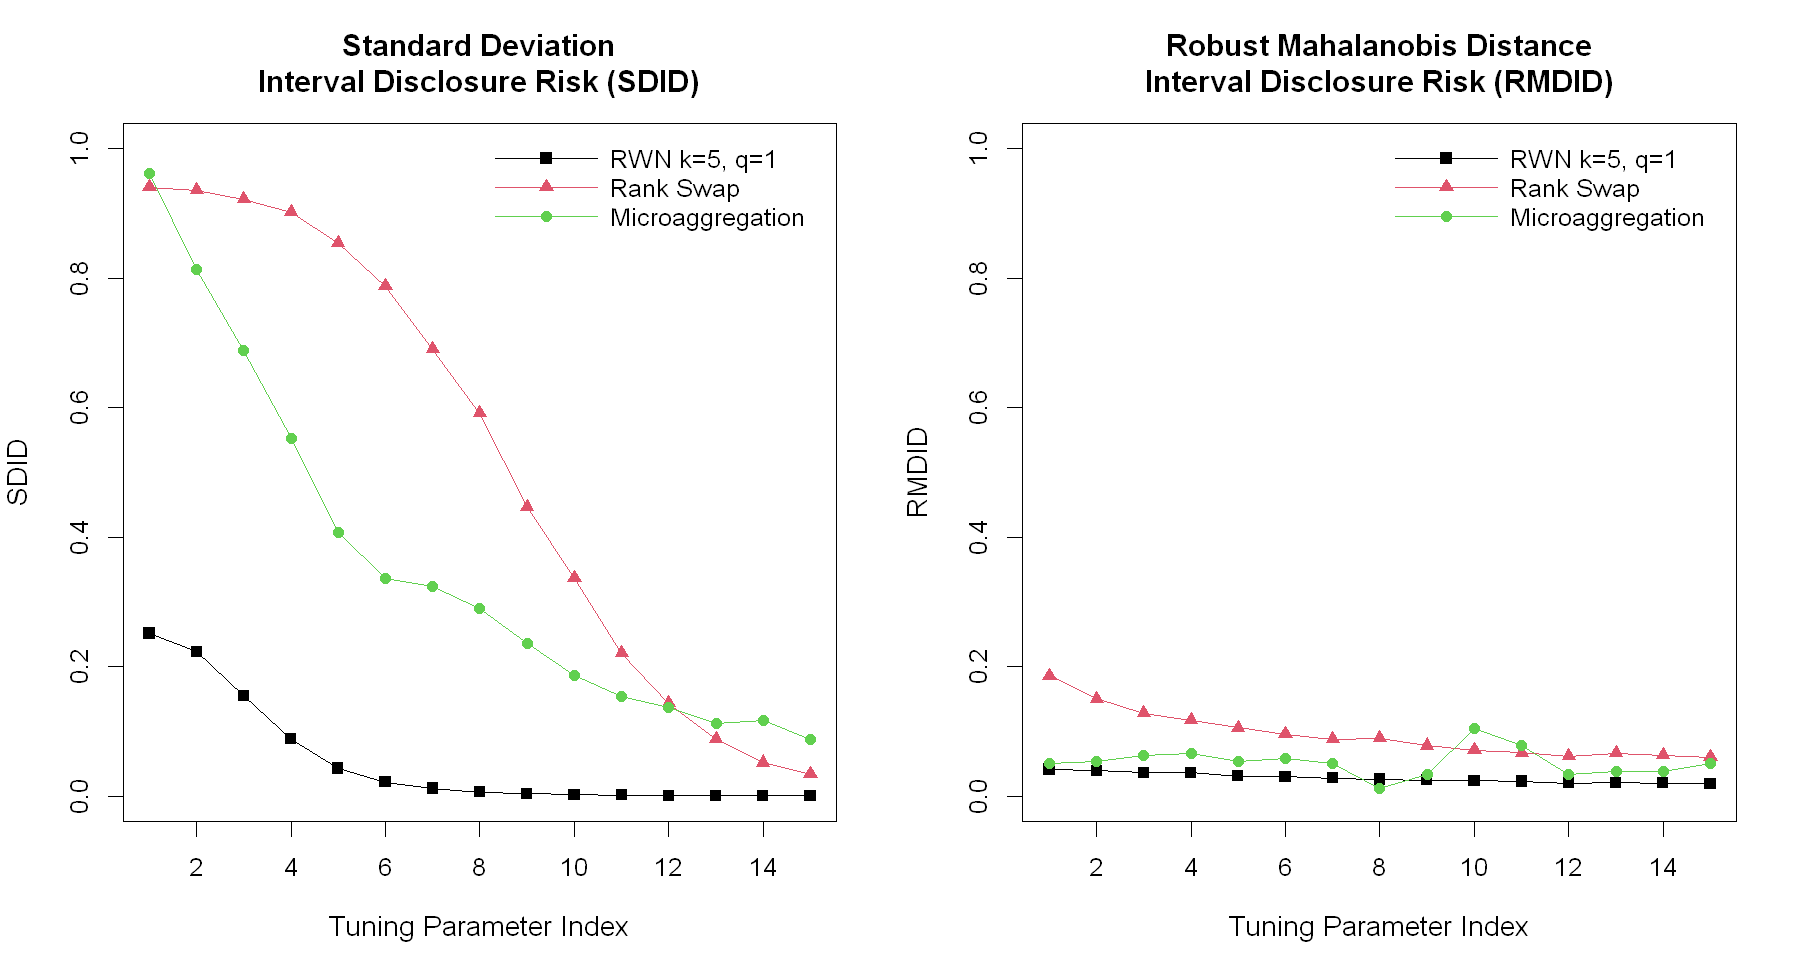

In [14]:
# Interval disclosure plots
par(mfrow = c(1,2))
options(repr.plot.width=12, repr.plot.height=6.5, repr.plot.res = 150)

plot(SDID_rwn_k5_vec, 
     main = "Standard Deviation\nInterval Disclosure Risk (SDID)",
     #sub = "Note: Lower SDID implies lower disclosure risk", col.sub = "gray30",
     col = 1, pch = 15,
     xlim = c(1,15), ylim = c(0,1),
     xlab = "Tuning Parameter Index", ylab = "SDID", cex.lab = 1.1)
lines(SDID_rwn_k5_vec, col = 1)

points(SDID_rs_vec, col = 2, pch = 17)
lines(SDID_rs_vec, col = 2)

points(SDID_ma_vec, col = 3, pch = 19)
lines(SDID_ma_vec, col = 3)

legend(x = 8, y = 1.03, lty = 1, pch = c(15,17,19) ,col = 1:3, bty = "n", x.intersp = 0.25,
       legend = c("RWN k=5, q=1", "Rank Swap", "Microaggregation"))


plot(RMDID_rwn_k5_vec, 
     main = "Robust Mahalanobis Distance\nInterval Disclosure Risk (RMDID)",
     #sub = "Note: Lower RMDID implies lower disclosure risk", col.sub = "gray30", cex.sub = 1.1,
     col = 1, pch = 15,
     xlim = c(1,15), ylim = c(0,1),
     xlab = "Tuning Parameter Index", ylab = "RMDID", cex.lab = 1.1)
lines(RMDID_rwn_k5_vec, col = 1)

points(RMDID_rs_vec, col = 2, pch = 17)
lines(RMDID_rs_vec, col = 2)

points(RMDID_ma_vec, col = 3, pch = 19)
lines(RMDID_ma_vec, col = 3)

legend(x = 8, y = 1.03, lty = 1, pch = c(15,17,19) ,col = 1:3, bty = "n", x.intersp = 0.25,
       legend = c("RWN k=5, q=1", "Rank Swap", "Microaggregation"))

### Utility Comparison: Pearson Correlation
Mean absolute difference between original and perturbed correlation matrices.

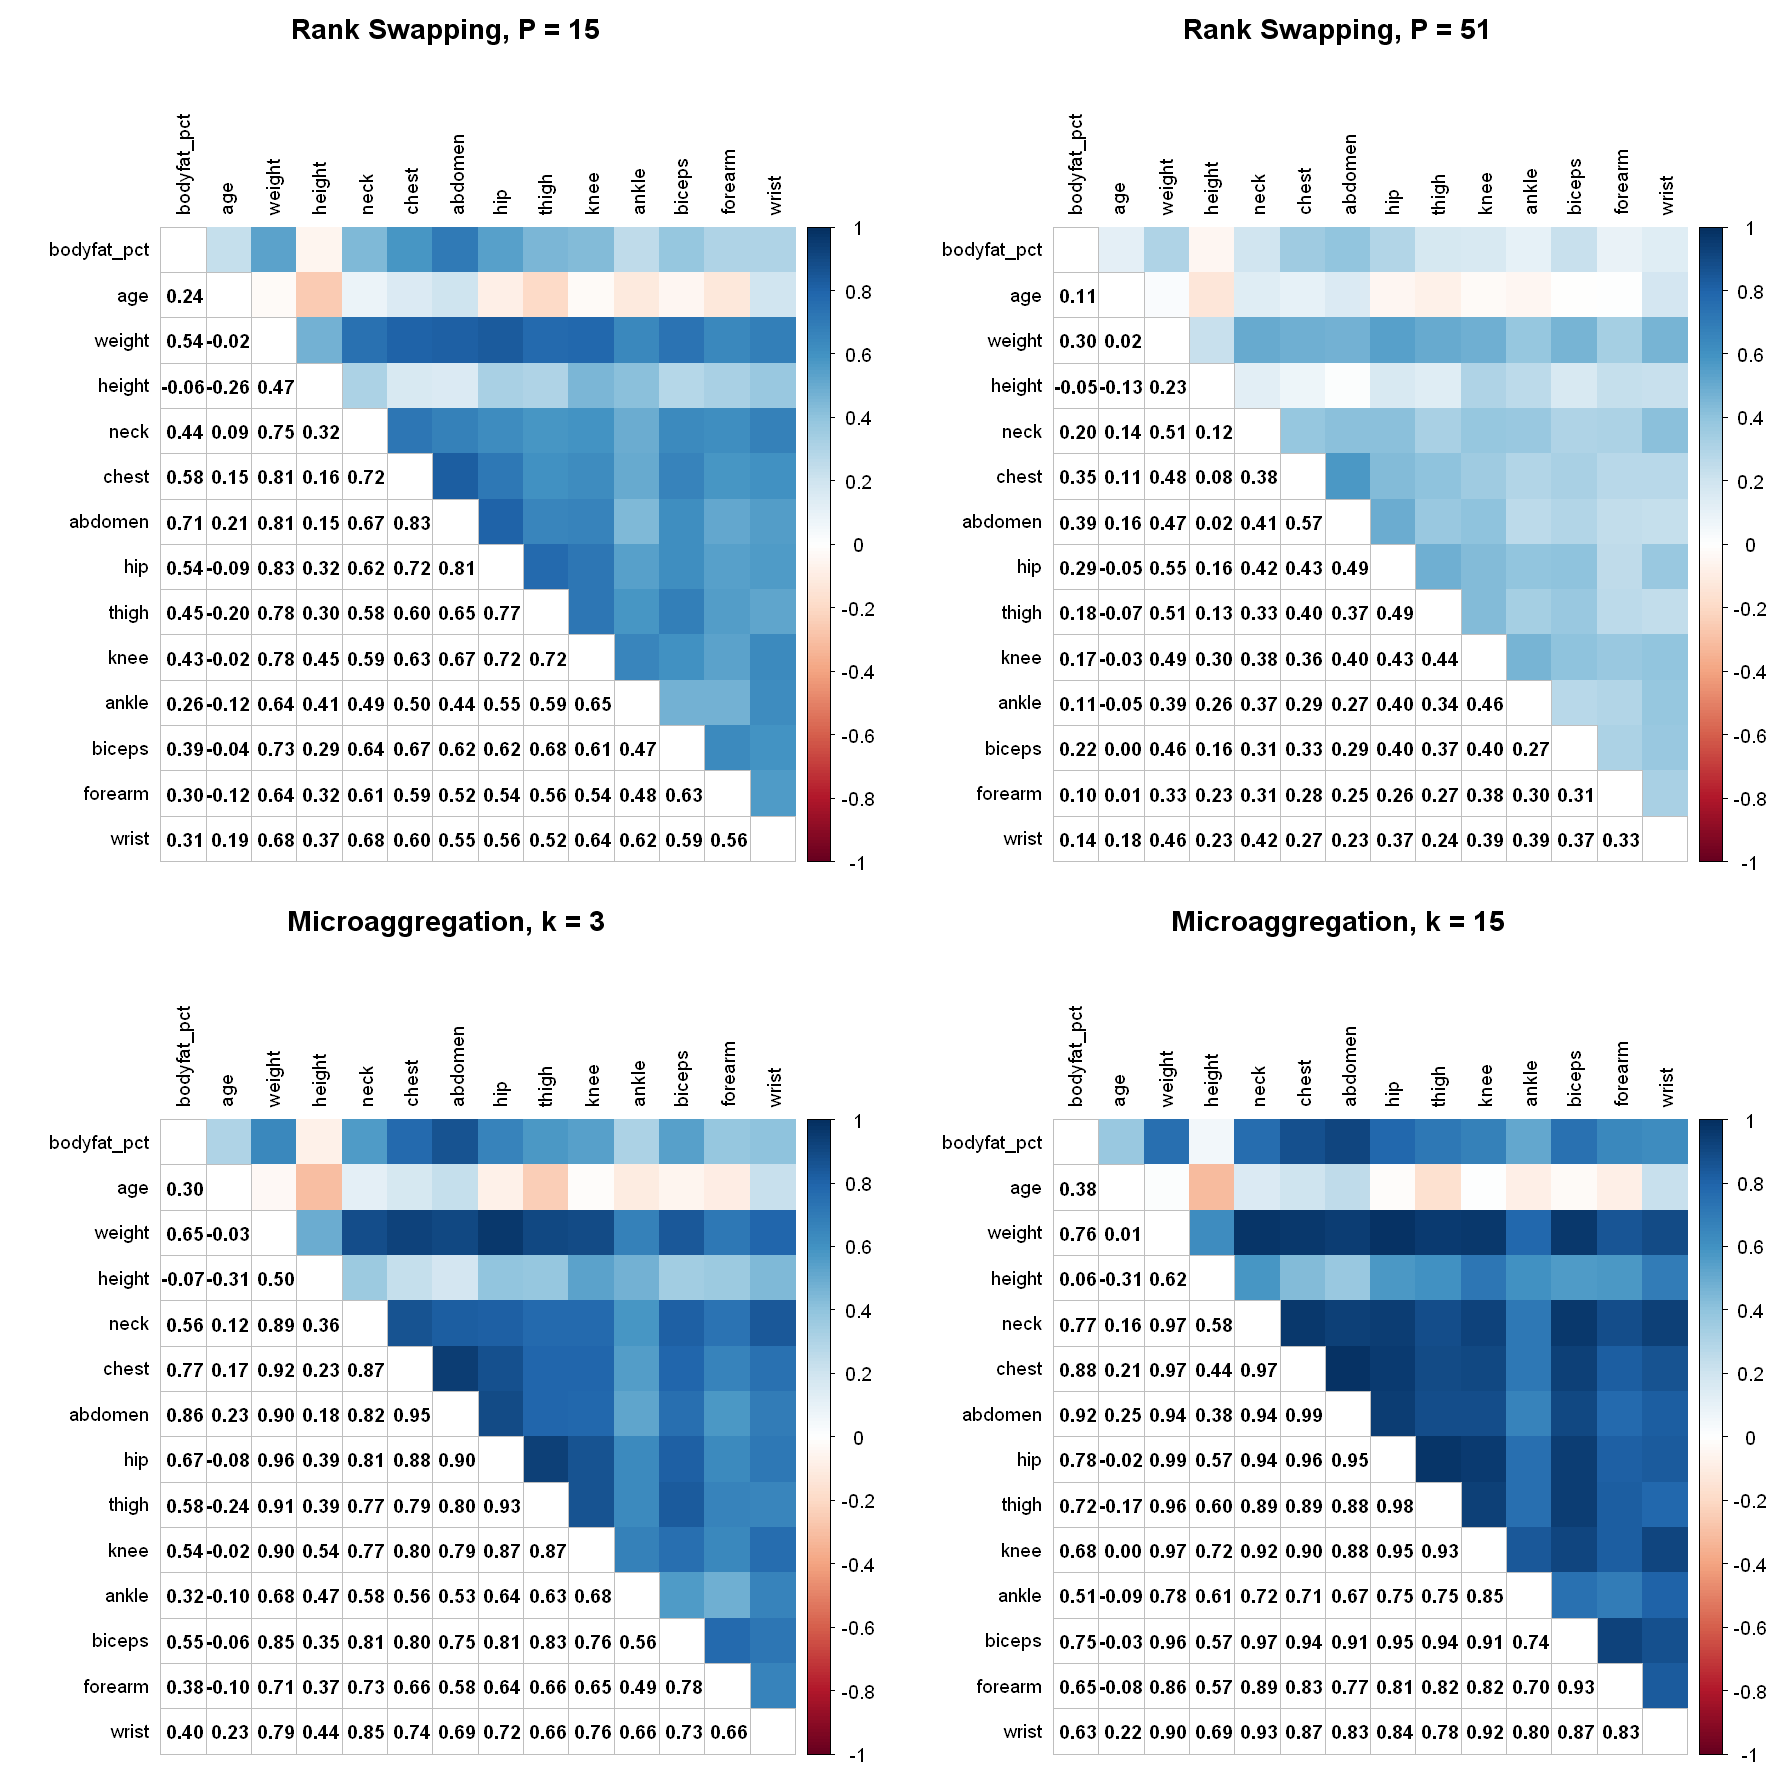

In [15]:
par(mfrow = c(2,2))
options(repr.plot.width=10.5, repr.plot.height=10.5, repr.plot.res = 170)

corrplot.mixed(cor(bf_rs_P15_v1), upper = 'color', lower = 'number',
               title = 'Rank Swapping, P = 15', mar = c(0, 0, 2, 0),
               lower.col = 'black', number.cex = .8, 
               tl.pos = 'lt', tl.cex = .8, tl.col = 'black')

corrplot.mixed(cor(bf_rs_P51_v1), upper = 'color', lower = 'number',
               title = 'Rank Swapping, P = 51', mar = c(0, 0, 2, 0),
               lower.col = 'black', number.cex = .8, 
               tl.pos = 'lt', tl.cex = .8, tl.col = 'black')

corrplot.mixed(cor(bf_ma_k3), upper = 'color', lower = 'number',
               title = 'Microaggregation, k = 3', mar = c(0, 0, 2, 0),
               lower.col = 'black', number.cex = .8, 
               tl.pos = 'lt', tl.cex = .8, tl.col = 'black')

corrplot.mixed(cor(bf_ma_k15), upper = 'color', lower = 'number',
               title = 'Microaggregation, k = 15', mar = c(0, 0, 2, 0),
               lower.col = 'black', number.cex = .8, 
               tl.pos = 'lt', tl.cex = .8, tl.col = 'black')

In [16]:
corMeanAbsDif_rwn_k5_mat <- matrix(nrow = length(eps_vec), ncol = reps)
corMeanAbsDif_rs_mat <- matrix(nrow = length(eps_vec), ncol = reps)
corMeanAbsDif_ma_vec <- vector(mode = "numeric", length = length(eps_vec))

for(i in 1:length(eps_vec)){
    for(j in reps_vec){
        corMeanAbsDif_rwn_k5_mat[i,j] <- corMeanAbsDif(bf_clean, e(paste0("bf_pert_eps", eps_vec[i], "_k5_v", j, "$zperturb")))
        corMeanAbsDif_rs_mat[i,j] <- corMeanAbsDif(bf_clean, e(paste0("bf_rs_P", P_pct_vec[i], "_v", j)))
    }
    corMeanAbsDif_ma_vec[i] <- corMeanAbsDif(bf_clean, e(paste0("bf_ma_k", aggr_vec[i])))
}

corMeanAbsDif_rwn_k5_vec <- rowMeans(corMeanAbsDif_rwn_k5_mat)
corMeanAbsDif_rs_vec <- rowMeans(corMeanAbsDif_rs_mat)

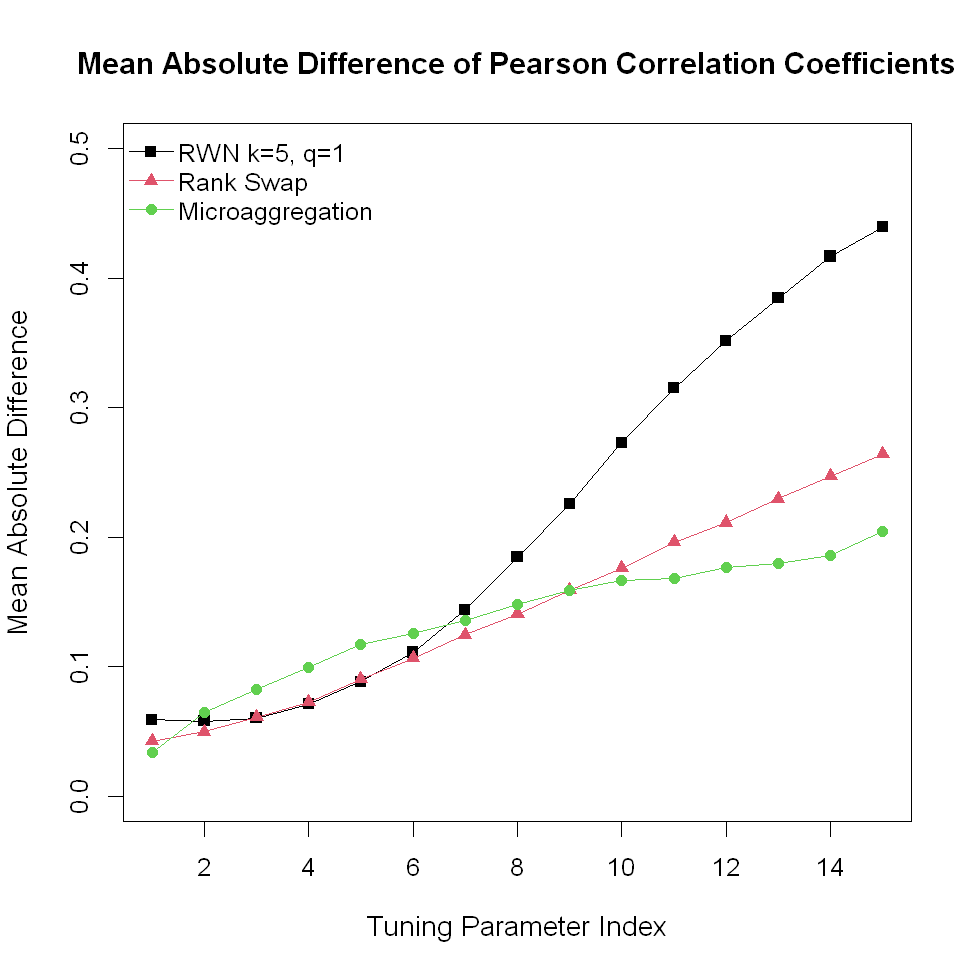

In [17]:
options(repr.plot.width=6.5, repr.plot.height=6.5, repr.plot.res = 150)

plot(corMeanAbsDif_rwn_k5_vec, 
     main = "Mean Absolute Difference of Pearson Correlation Coefficients",
     #sub = "Note: Lower mean absolute difference implies less information loss", col.sub = "gray30", cex.sub = 1.1,
     col = 1, pch = 15,
     xlim = c(1,15), ylim = c(0,0.5),
     xlab = "Tuning Parameter Index", ylab = "Mean Absolute Difference", cex.lab = 1.1)
lines(corMeanAbsDif_rwn_k5_vec, col = 1)

points(corMeanAbsDif_rs_vec, col = 2, pch = 17)
lines(corMeanAbsDif_rs_vec, col = 2)

points(corMeanAbsDif_ma_vec, col = 3, pch = 19)
lines(corMeanAbsDif_ma_vec, col = 3)

legend(x = "topleft", lty = 1, pch = c(15,17,19), col = 1:3, bty = "n", x.intersp = 0.25,
       legend = c("RWN k=5, q=1", "Rank Swap", "Microaggregation"))

### Utility Comparison: Principal Component Analysis Loadings
Mean absolute difference between original and perturbed PCA loading matrices.

This metric is included in sdcMicro in the summary.micro() function

In [18]:
pcaloadMeanAbsDif_rwn_k5_mat1 <- matrix(nrow = length(eps_vec), ncol = reps)
pcaloadMeanAbsDif_rs_mat1 <- matrix(nrow = length(eps_vec), ncol = reps)
pcaloadMeanAbsDif_ma_vec1 <- vector(mode = "numeric", length = length(eps_vec))

for(i in 1:length(eps_vec)){
    for(j in reps_vec){
        pcaloadMeanAbsDif_rwn_k5_mat1[i,j] <- pcaloadMeanAbsDif(bf_clean, 
                                                               e(paste0("bf_pert_eps", eps_vec[i], "_k5_v", j, "$zperturb")),
                                                               pc_vec = 1)
        pcaloadMeanAbsDif_rs_mat1[i,j] <- pcaloadMeanAbsDif(bf_clean, 
                                                           e(paste0("bf_rs_P", P_pct_vec[i], "_v", j)),
                                                           pc_vec = 1)
    }
    pcaloadMeanAbsDif_ma_vec1[i] <- pcaloadMeanAbsDif(bf_clean, 
                                                     e(paste0("bf_ma_k", aggr_vec[i])),
                                                     pc_vec = 1)
}

pcaloadMeanAbsDif_rwn_k5_vec1 <- rowMeans(pcaloadMeanAbsDif_rwn_k5_mat1)
pcaloadMeanAbsDif_rs_vec1 <- rowMeans(pcaloadMeanAbsDif_rs_mat1)

In [19]:
pcaloadMeanAbsDif_rwn_k5_mat2 <- matrix(nrow = length(eps_vec), ncol = reps)
pcaloadMeanAbsDif_rs_mat2 <- matrix(nrow = length(eps_vec), ncol = reps)
pcaloadMeanAbsDif_ma_vec2 <- vector(mode = "numeric", length = length(eps_vec))

for(i in 1:length(eps_vec)){
    for(j in reps_vec){
        pcaloadMeanAbsDif_rwn_k5_mat2[i,j] <- pcaloadMeanAbsDif(bf_clean, 
                                                               e(paste0("bf_pert_eps", eps_vec[i], "_k5_v", j, "$zperturb")),
                                                               pc_vec = 2)
        pcaloadMeanAbsDif_rs_mat2[i,j] <- pcaloadMeanAbsDif(bf_clean, 
                                                           e(paste0("bf_rs_P", P_pct_vec[i], "_v", j)),
                                                           pc_vec = 2)
    }
    pcaloadMeanAbsDif_ma_vec2[i] <- pcaloadMeanAbsDif(bf_clean, 
                                                     e(paste0("bf_ma_k", aggr_vec[i])),
                                                     pc_vec = 2)
}

pcaloadMeanAbsDif_rwn_k5_vec2 <- rowMeans(pcaloadMeanAbsDif_rwn_k5_mat2)
pcaloadMeanAbsDif_rs_vec2 <- rowMeans(pcaloadMeanAbsDif_rs_mat2)

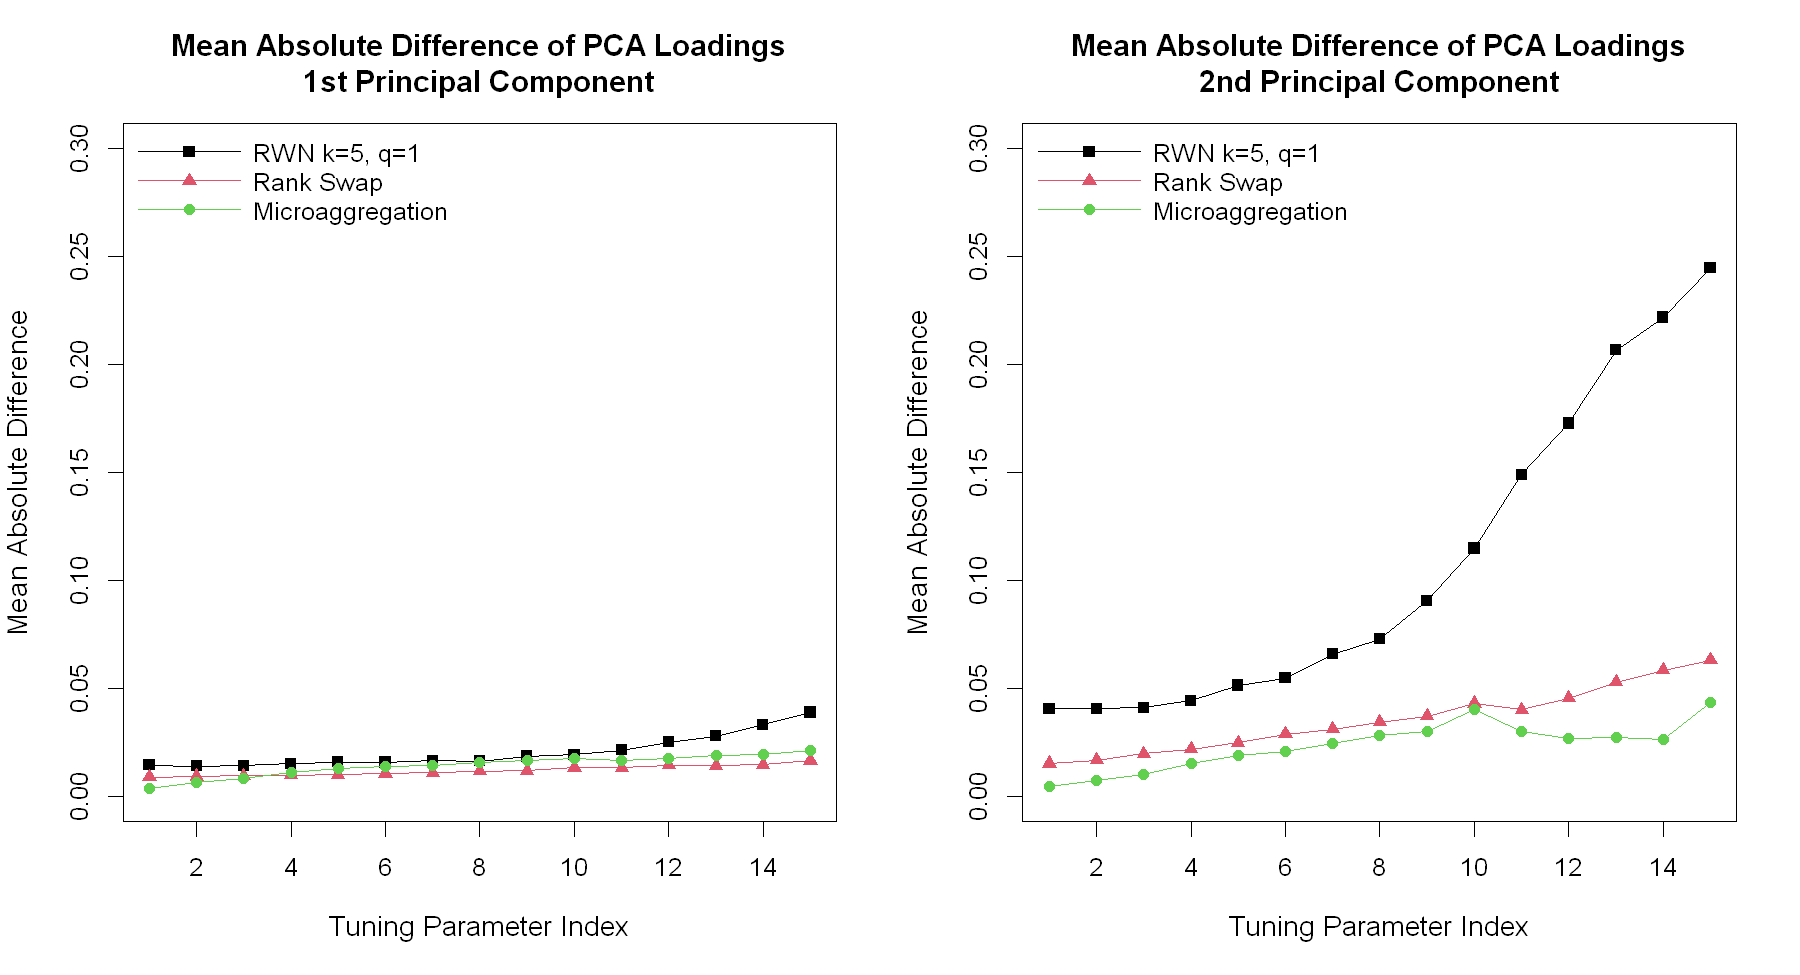

In [20]:
# PCA Loading Plot
par(mfrow = c(1,2))
options(repr.plot.width=12, repr.plot.height=6.5, repr.plot.res = 150)

plot(pcaloadMeanAbsDif_rwn_k5_vec1, 
     main = "Mean Absolute Difference of PCA Loadings\n1st Principal Component",
     #sub = "Note: Lower mean absolute difference implies less information loss", col.sub = "gray30", cex.sub = 1.1,
     col = 1, pch = 15,
     xlim = c(1,15), ylim = c(0,0.3),
     xlab = "Tuning Parameter Index", ylab = "Mean Absolute Difference", cex.lab = 1.1)
lines(pcaloadMeanAbsDif_rwn_k5_vec1, col = 1)

points(pcaloadMeanAbsDif_rs_vec1, col = 2, pch = 17)
lines(pcaloadMeanAbsDif_rs_vec1, col = 2)

points(pcaloadMeanAbsDif_ma_vec1, col = 3, pch = 19)
lines(pcaloadMeanAbsDif_ma_vec1, col = 3)

legend(x = "topleft", lty = 1, pch = c(15,17,19) ,col = 1:3, bty = "n", x.intersp = 0.25,
       legend = c("RWN k=5, q=1", "Rank Swap", "Microaggregation"))


plot(pcaloadMeanAbsDif_rwn_k5_vec2, 
     main = "Mean Absolute Difference of PCA Loadings\n2nd Principal Component",
     #sub = "Note: Lower mean absolute difference implies less information loss", col.sub = "gray30", cex.sub = 1.1,
     col = 1, pch = 15,
     xlim = c(1,15), ylim = c(0,0.3),
     xlab = "Tuning Parameter Index", ylab = "Mean Absolute Difference", cex.lab = 1.1)
lines(pcaloadMeanAbsDif_rwn_k5_vec2, col = 1)

points(pcaloadMeanAbsDif_rs_vec2, col = 2, pch = 17)
lines(pcaloadMeanAbsDif_rs_vec2, col = 2)

points(pcaloadMeanAbsDif_ma_vec2, col = 3, pch = 19)
lines(pcaloadMeanAbsDif_ma_vec2, col = 3)

legend(x = "topleft", lty = 1, pch = c(15,17,19) ,col = 1:3, bty = "n", x.intersp = 0.25,
       legend = c("RWN k=5, q=1", "Rank Swap", "Microaggregation"))

### Utility Comparison: Regression

Mean absolute difference between original and perturbed regression coefficients.

In [21]:
# Regression Coefficient Calculations
regcoefMeanAbsDif_rwn_k5_mat <- matrix(nrow = length(eps_vec), ncol = reps)
regcoefMeanAbsDif_rs_mat <- matrix(nrow = length(eps_vec), ncol = reps)
regcoefMeanAbsDif_ma_vec <- vector(mode = "numeric", length = length(eps_vec))

for(i in 1:length(eps_vec)){
    for(j in reps_vec){
        regcoefMeanAbsDif_rwn_k5_mat[i,j] <- reg_utilityMetrics(orig_data = bf_clean,
                                                          pert_data = e(paste0("bf_pert_eps", eps_vec[i], "_k5_v", j, "$zperturb")),
                                                          metric = "coefMeanAbsDif", regvars = "all")
        regcoefMeanAbsDif_rs_mat[i,j] <- reg_utilityMetrics(orig_data = bf_clean,
                                                      pert_data = e(paste0("bf_rs_P", P_pct_vec[i], "_v", j)),
                                                      metric = "coefMeanAbsDif", regvars = "all")
        }
    regcoefMeanAbsDif_ma_vec[i] <- reg_utilityMetrics(orig_data = bf_clean,
                                                      pert_data = e(paste0("bf_ma_k", aggr_vec[i])),
                                                      metric = "coefMeanAbsDif", regvars = "all")
}

regcoefMeanAbsDif_rwn_k5_vec <- rowMeans(regcoefMeanAbsDif_rwn_k5_mat)
regcoefMeanAbsDif_rs_vec <- rowMeans(regcoefMeanAbsDif_rs_mat)

In [22]:
# Regression R-squared Calculations
rsquared_rwn_k5_mat <- matrix(nrow = length(eps_vec), ncol = reps)
rsquared_rs_mat <- matrix(nrow = length(eps_vec), ncol = reps)
rsquared_ma_vec <- vector(mode = "numeric", length = length(eps_vec))

rsquared_orig <- reg_utilityMetrics(orig_data = bf_clean, 
                                    pert_data = bf_clean, 
                                    metric = "rsquared",
                                    regvars = "all")
    # Note: when metric = "rsquared", orig_data is not used for R-squared calculation

for(i in 1:length(eps_vec)){
    for(j in reps_vec){
        rsquared_rwn_k5_mat[i,j] <- reg_utilityMetrics(orig_data = bf_clean,
                                                    pert_data = e(paste0("bf_pert_eps", eps_vec[i], "_k5_v", j, "$zperturb")),
                                                    metric = "rsquared", regvars = "all")
        rsquared_rs_mat[i,j] <- reg_utilityMetrics(orig_data = bf_clean,
                                                pert_data = e(paste0("bf_rs_P", P_pct_vec[i], "_v", j)),
                                                metric = "rsquared", regvars = "all")
    }
    rsquared_ma_vec[i] <- reg_utilityMetrics(orig_data = bf_clean,
                                             pert_data = e(paste0("bf_ma_k", aggr_vec[i])),
                                             metric = "rsquared", regvars = "all")
}

rsquared_rwn_k5_vec <- rowMeans(rsquared_rwn_k5_mat)
rsquared_rs_vec <- rowMeans(rsquared_rs_mat)

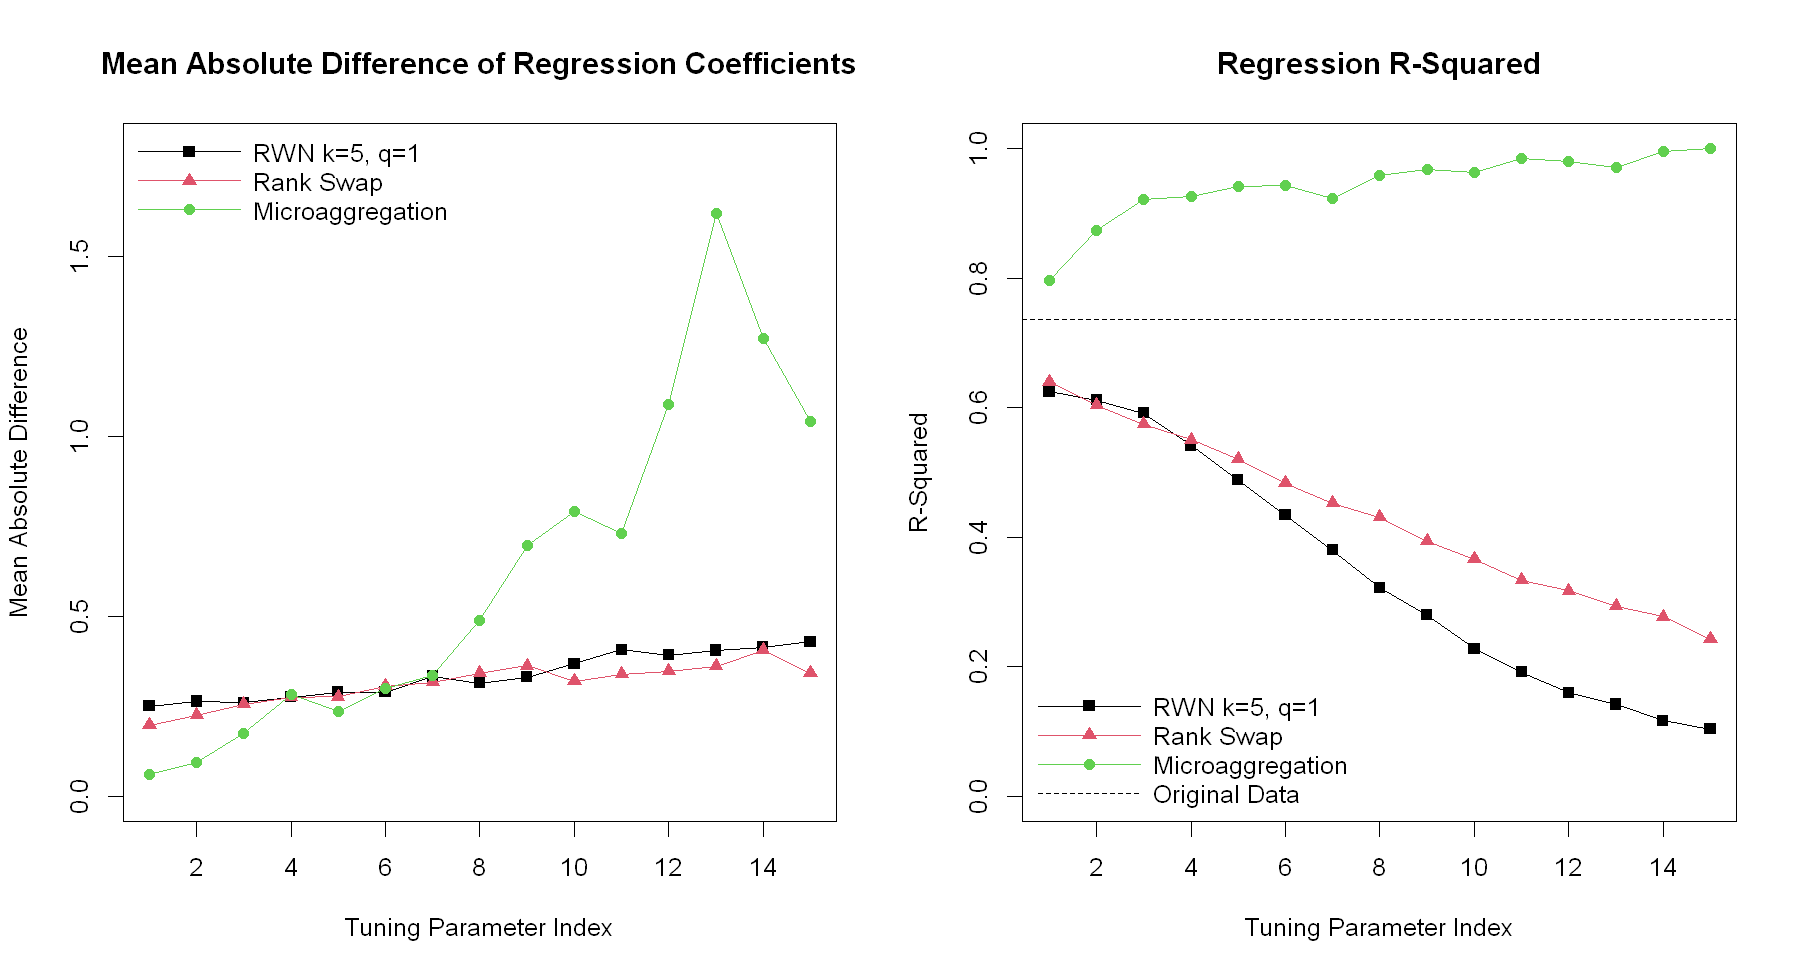

In [23]:
# Regression Plots
par(mfrow = c(1,2))
options(repr.plot.width=12, repr.plot.height=6.5, repr.plot.res = 150)

plot(regcoefMeanAbsDif_rwn_k5_vec, 
     main = "Mean Absolute Difference of Regression Coefficients",
     #sub = "Note: Lower mean absolute difference implies less information loss", col.sub = "gray30", cex.sub = 1.1,
     col = 1, pch = 15,
     xlim = c(1,15), ylim = c(0,1.8),
     xlab = "Tuning Parameter Index", ylab = "Mean Absolute Difference", cex.sub = 1.1)
lines(regcoefMeanAbsDif_rwn_k5_vec, col = 1)

points(regcoefMeanAbsDif_rs_vec, col = 2, pch = 17)
lines(regcoefMeanAbsDif_rs_vec, col = 2)

points(regcoefMeanAbsDif_ma_vec, col = 3, pch = 19)
lines(regcoefMeanAbsDif_ma_vec, col = 3)

legend(x = "topleft", lty = 1, pch = c(15,17,19) ,col = 1:3, bty = "n", x.intersp = 0.25,
       legend = c("RWN k=5, q=1", "Rank Swap", "Microaggregation"))


plot(rsquared_rwn_k5_vec, 
     main = "Regression R-Squared",
     col = 1, pch = 15,
     xlim = c(1,15), ylim = c(0,1),
     xlab = "Tuning Parameter Index", ylab = "R-Squared")
lines(rsquared_rwn_k5_vec, col = 1)

points(rsquared_rs_vec, col = 2, pch = 17)
lines(rsquared_rs_vec, col = 2)

points(rsquared_ma_vec, col = 3, pch = 19)
lines(rsquared_ma_vec, col = 3)

abline(a = rsquared_orig, b = 0, lty = 2, col = 1)

legend(x = "bottomleft", lty = c(1,1,1,2), pch = c(15,17,19,NA) ,col = c(1,2,3,1), bty = "n", x.intersp = 0.25, 
       legend = c("RWN k=5, q=1", "Rank Swap", "Microaggregation", "Original Data"))

In [24]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] mfp_1.5.4        survival_3.5-5   pdist_1.2.1      regtools_1.7.0  
[5] FNN_1.1.3.2      sdcMicro_5.7.6   infotheo_1.2.0.1 gtools_3.9.4    
[9] corrplot_0.92   

loaded via a namespace (and not attached):
 [1] jsonlite_1.8.4      splines_4.1.3       foreach_1.5.2      
 [4] RhpcBLASctl_0.23-42 prettydoc_0.4.1     carData_3.0-5      
 [7] shiny_1.7.5         lgr_0.4.4           rhandsontable_0.3.8
[10] robustbase_0.99-0   numDeriv_2016.8-1.1 pillar_1.9.0       
[13] lattice_0.21-8      gl